## ARIMA model for NYC electricity price & temperature

In [75]:
import pandas as pd
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
from datetime import timedelta 
from datetime import datetime

In [2]:
df_price = pd.read_csv('nyiso_NYC_price.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_load = pd.read_csv('nyiso_NYC_load.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_temp = pd.read_csv('la_guardia_airport_2017_local_time.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [85]:
test = start_date + timedelta(days = 8)
test, start_date

(datetime.datetime(2017, 1, 7, 0, 0), datetime.datetime(2016, 12, 31, 0, 0))

In [87]:
df_price.tail(2)

,time_stamp,price,time_stamp_local,price_24hr_ago,price_deseason
214,2017-01-09 03:00:00,55.85,2017-01-08 22:00:00,65.68,-9.83
215,2017-01-09 04:00:00,64.56,2017-01-08 23:00:00,70.77,-6.21


In [88]:
start_date = pd.datetime(2016, 12, 31)
end_date = start_date + timedelta(days = 8)
may1st_index_price = (df_price.time_stamp_local >= start_date) & \
                     (df_price.time_stamp_local < end_date)
may1st_index_temp = (df_temp.time_stamp_local >= start_date) & \
                     (df_temp.time_stamp_local < end_date)

may1st_index_load = (df_load.time_stamp_local >= start_date) & \
                    (df_load.time_stamp_local < end_date)

df_price = df_price.loc[may1st_index_price, :].reset_index(drop = True)
df_temp = df_temp.loc[may1st_index_temp, :].reset_index(drop = True)
df_load = df_load.loc[may1st_index_load, :].reset_index(drop = True)

df_price.shape, df_temp.shape, df_load.shape

((192, 5), (192, 5), (192, 5))

In [89]:
df_price.columns, df_temp.columns

(Index(['time_stamp', 'price', 'time_stamp_local', 'price_24hr_ago',
        'price_deseason'],
       dtype='object'),
 Index(['time_stamp', 'temp', 'time_stamp_local', 'temp_24hr_ago',
        'temp_deseason'],
       dtype='object'))

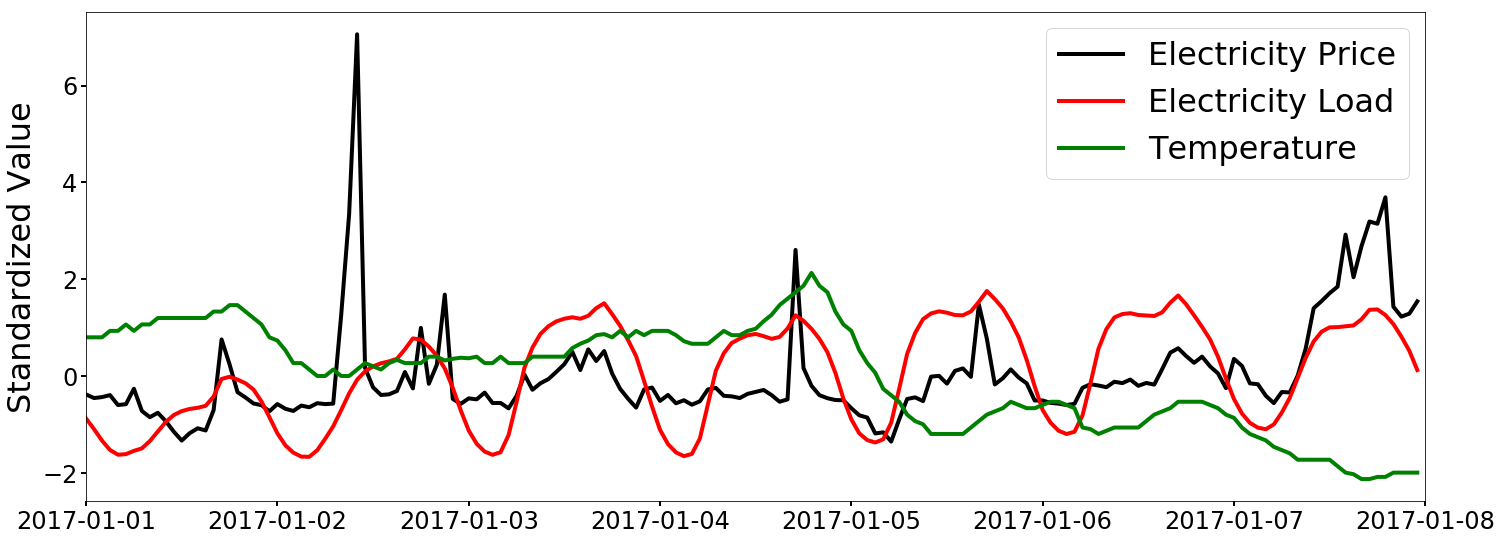

In [90]:
fig, ax = plt.subplots(figsize = (24, 9))
ax.plot(df_price.iloc[:,2], preprocessing.scale(df_price.iloc[:,1]), linewidth = 4
        , color = 'black', label = 'Electricity Price')
ax.plot(df_load.iloc[:,2], preprocessing.scale(df_load.iloc[:,1]), linewidth = 4
        , color = 'red', label = 'Electricity Load')
ax.plot(df_temp.iloc[:,2], preprocessing.scale(df_temp.iloc[:,1]), linewidth = 4
        , color = 'green', label = 'Temperature')
ax.legend(fontsize = 32)
ax.set_ylabel('Standardized Value', fontsize = 32)
ax.set_xlim(start_date + timedelta(days = 1), end_date)
# ax.set_ylim(-2, 11)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#plt.savefig('price_load_temp_2018.pdf', format = 'pdf')

In [55]:
# # remove daily seasonality
# def remove_seasonality(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return np.array(diff)
# # invert differenced value
# def restore_seasonality(history, yhat, interval=1):
#     return yhat + history[-interval]

In [91]:
def daily_diff(df, name):
    df.loc[:, name + '_24hr_ago'] = df.loc[:, name].shift(periods = 24)
    df.loc[:, name + '_deseason'] = df.loc[:, name] - df.loc[:, name + '_24hr_ago']
    return df.dropna()

In [92]:
df_price['price_24hr_ago'] = df_price.price.shift(periods = 24)
df_price['price_deseason'] = df_price.price - df_price.price_24hr_ago
X_price = df_price.dropna()

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


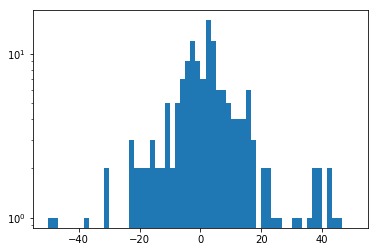

In [93]:
plt.hist(df_price.price_deseason, range = (-50, 50), bins = 60, log = True);

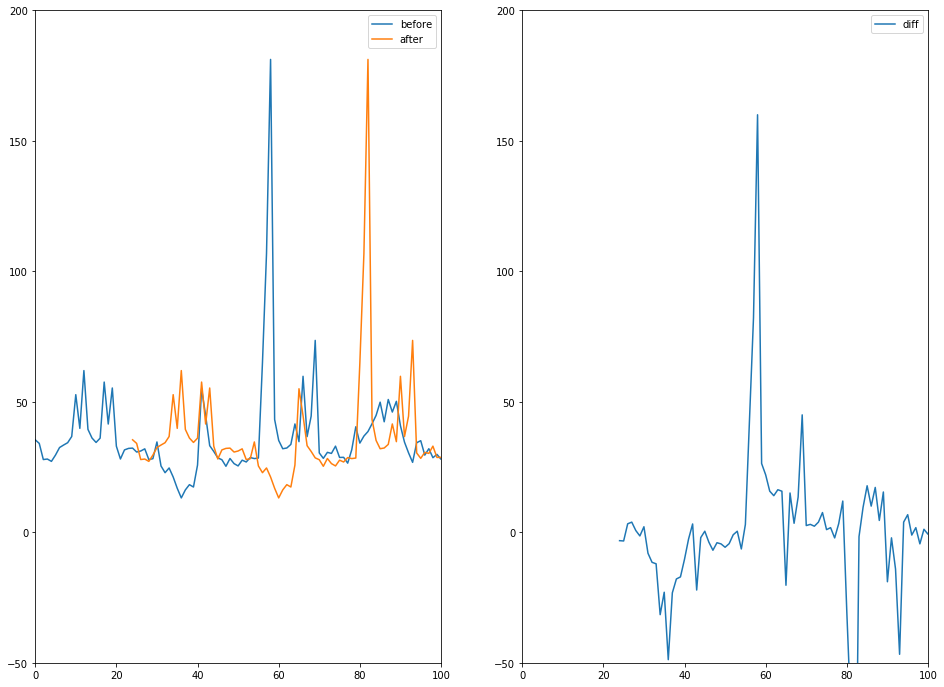

In [94]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 12))
ax[0].plot(df_price.price, label = 'before')
ax[0].plot(df_price.price_24hr_ago, label = 'after')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(-50, 200)
ax[0].legend()
ax[1].plot(df_price.price_deseason, label = 'diff')
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-50, 200)
ax[1].legend()

## Statistical test

In [95]:
def plot_acf(df, X, name):
    fig, axes = plt.subplots(2, 2, figsize=(16,9))

    fig = sm.graphics.tsa.plot_acf(df.loc[:,name], lags=90, ax=axes[0, 0])
    fig = sm.graphics.tsa.plot_pacf(df.loc[:,name], lags=90, ax=axes[0, 1])

    fig = sm.graphics.tsa.plot_acf(X.loc[:, name + '_deseason'], lags=30, ax=axes[1, 0])
    fig = sm.graphics.tsa.plot_pacf(X.loc[:, name + '_deseason'], lags=30, ax=axes[1, 1])

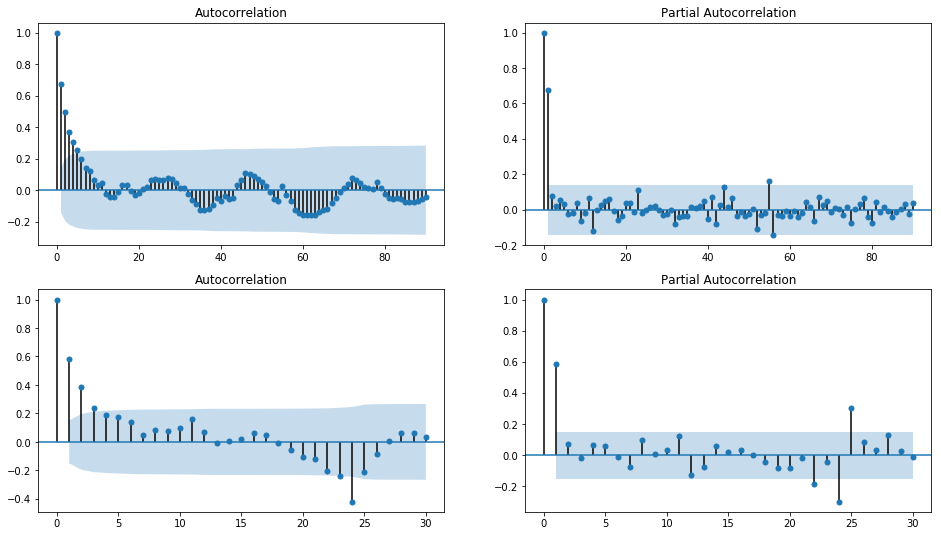

In [96]:
plot_acf(df_price, X_price, 'price')
# # Graph data
# fig, axes = plt.subplots(2, 2, figsize=(16,9))

# fig = sm.graphics.tsa.plot_acf(df_price.price, lags=90, ax=axes[0, 0])
# fig = sm.graphics.tsa.plot_pacf(df_price.price, lags=90, ax=axes[0, 1])

# fig = sm.graphics.tsa.plot_acf(X_price.price_deseason, lags=30, ax=axes[1, 0])
# fig = sm.graphics.tsa.plot_pacf(X_price.price_deseason, lags=30, ax=axes[1, 1])

### Augmented Dickey-Fuller Test

Time Series models are described in terms of autoregressive (AR) lags. So an AR(1) model states that the value at Y<sub>t</sub> depends on the value at Y<sub>t-1</sub>. So we can represent the time series as a model:

Y<sub>t</sub> = Alpha + Rho\*Y<sub>t-1</sub> + Error<sub>t</sub>

It turns out, a time series is perfectly stationary when Rho = 0. This makes intuitive sense: The time series will not depend on its previous value when Rho is 0, so it depends entirely on error and is equivalent to a random walk. A time series is perfectly non-stationary if Rho = 1. Alpha is a coeffecient that we want to estimate such that the Error term is minimized, but let's worry about that later.

The Dickey-Fuller Test asks if Rho in an AR(1) model is equal to 0 (H<sub>0</sub>: Rho=1, H<sub>1</sub>: Rho<1)

The augmented Dickey-Fuller Test just expands this to work for AR(n) models

**A p-value < 0.05 indicates that your time series IS STATIONARY.**

In [97]:
# the statsmodels output is ugly and unlabeled, lets use a function to format it nicely
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [98]:
dftest_price = adfuller(X_price.price_deseason.values, autolag='AIC')
#dftest_temp = adfuller(df_temp.temp.values, autolag='AIC')

adf_output(dftest_price)
#adf_output(dftest_temp)

Test Statistic                -6.498014e+00
p-value                        1.180932e-08
# of Lags Used                 0.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (10%)          -2.576083e+00
Critical Value (1%)           -3.470126e+00
Critical Value (5%)           -2.879008e+00
dtype: float64


## Train ARIMA model

In [99]:
# train_ratio = 0.8
# valid_ratio = 1. - train_ratio
# use the last day as validation
X_train = X_price.price_deseason.values[:X_price.shape[0] - 1]
X_valid = X_price.price_deseason.values[X_price.shape[0] - 1:]
X_train.shape, X_valid.shape

((167,), (1,))

In [100]:
#model = ARIMA(X_price.price_deseason.values, order=(3,0,1))
model = ARIMA(X_train, order=(3,0,3))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  167
Model:                     ARMA(3, 3)   Log Likelihood                -738.243
Method:                       css-mle   S.D. of innovations             19.842
Date:                Thu, 01 Feb 2018   AIC                           1492.486
Time:                        06:23:03   BIC                           1517.430
Sample:                             0   HQIC                          1502.610
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8594      4.107      0.940      0.349      -4.189      11.908
ar.L1.y        0.2279      0.153      1.490      0.138      -0.072       0.528
ar.L2.y       -0.5556      0.066     -8.422      0.0

In [101]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=1)[0]
# hours_in_day = 24
# inverted = restore_seasonality(history, yhat, hours_in_day)
# invert the differenced forecast to something usable
# history = [x for x in X_price.price.values[:X_price.shape[0] - 1]]
# hour = 1
# hours_in_day = 24
# for yhat in forecast:
#     inverted = restore_seasonality(history, yhat, hours_in_day)
#     #print('Hour %d: %f' % (hour, inverted))
#     history.append(inverted)
#     hour += 1

In [102]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16, 9))
# ax[0].plot(X_price.price.values[:X_price.shape[0] - 1],'.')
# ax[0].plot(history)
# #ax[0].set_xlim(8650, 8750)
# #ax[0].set_ylim(0, 400)
# ax[1].plot(history[len(X_train):], label = 'prediction')
# ax[1].plot(X_valid, label = 'validation')
# ax[1].legend()
# #ax[1].set_xlim(8650, 8750)

## SMAPE

In [103]:
(X_valid, forecast)

(array([ 35.92]), array([ 22.4340567]))

## Add Load

In [104]:
df_load.head()

,time_stamp,load,time_stamp_local,load_24hr_ago,load_deseason
0,2016-12-31 05:00:00,5128.0,2016-12-31 00:00:00,NaN,NaN
1,2016-12-31 06:00:00,4896.2,2016-12-31 01:00:00,NaN,NaN
2,2016-12-31 07:00:00,4733.9,2016-12-31 02:00:00,NaN,NaN
3,2016-12-31 08:00:00,4640.7,2016-12-31 03:00:00,NaN,NaN
4,2016-12-31 09:00:00,4610.1,2016-12-31 04:00:00,NaN,NaN


In [105]:
X_load = daily_diff(df_load, 'load')

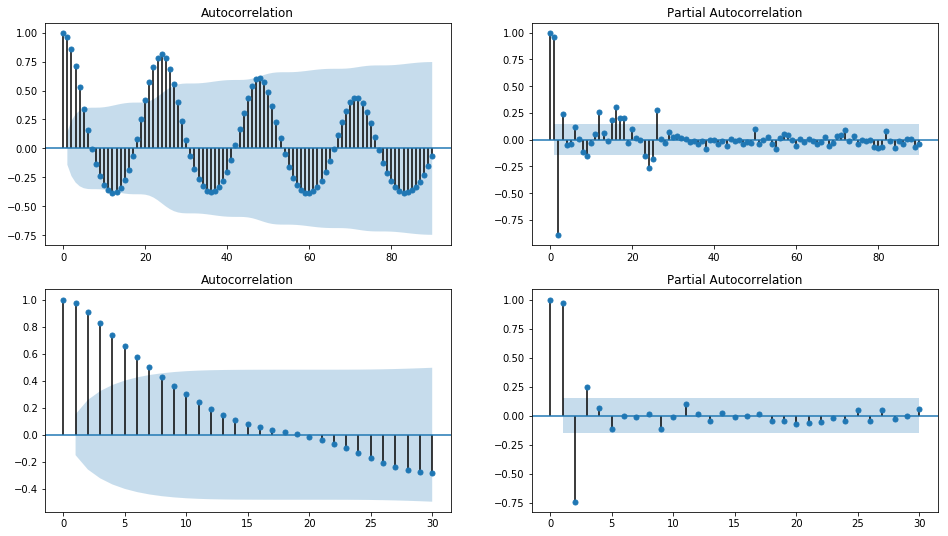

In [106]:
plot_acf(df_load, X_load, 'load')
# # Graph data
# fig, axes = plt.subplots(2, 2, figsize=(16,9))

# fig = sm.graphics.tsa.plot_acf(df_load.load, lags=90, ax=axes[0, 0])
# fig = sm.graphics.tsa.plot_pacf(df_load.load, lags=90, ax=axes[0, 1])

# fig = sm.graphics.tsa.plot_acf(X_load.load_deseason, lags=30, ax=axes[1, 0])
# fig = sm.graphics.tsa.plot_pacf(X_load.load_deseason, lags=30, ax=axes[1, 1])

In [107]:
#stationarity test
load_adf = adfuller(X_load.load.values, autolag='AIC')
load_deseason_adf = adfuller(X_load.load_deseason.values, autolag='AIC')
adf_output(load_adf)
adf_output(load_deseason_adf)

Test Statistic                  -2.464321
p-value                          0.124398
# of Lags Used                  14.000000
Number of Observations Used    153.000000
Critical Value (10%)            -2.576945
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
dtype: float64
Test Statistic                  -3.004606
p-value                          0.034466
# of Lags Used                   4.000000
Number of Observations Used    163.000000
Critical Value (10%)            -2.576314
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
dtype: float64


In [108]:
#causality test
granger = pd.DataFrame({'price':X_price.price.values, 'load':X_load.load.values})
granger = granger.dropna()
granger_test = grangercausalitytests(granger, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0281  , p=0.8672  , df_denom=164, df_num=1
ssr based chi2 test:   chi2=0.0286  , p=0.8658  , df=1
likelihood ratio test: chi2=0.0286  , p=0.8658  , df=1
parameter F test:         F=0.0281  , p=0.8672  , df_denom=164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0209  , p=0.3626  , df_denom=161, df_num=2
ssr based chi2 test:   chi2=2.1053  , p=0.3490  , df=2
likelihood ratio test: chi2=2.0921  , p=0.3513  , df=2
parameter F test:         F=1.0209  , p=0.3626  , df_denom=161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8027  , p=0.1489  , df_denom=158, df_num=3
ssr based chi2 test:   chi2=5.6476  , p=0.1301  , df=3
likelihood ratio test: chi2=5.5531  , p=0.1355  , df=3
parameter F test:         F=1.8027  , p=0.1489  , df_denom=158, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3169  , p=0.2661  

## Load & Price

In [163]:
model3=ARIMA(endog=X_price.price_deseason.values[:-1],
             exog=X_load.load_deseason.values[:-1],
             order=[3,0,3])
results3=model3.fit()
print(results3.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  167
Model:                     ARMA(3, 3)   Log Likelihood                -738.674
Method:                       css-mle   S.D. of innovations             19.926
Date:                Thu, 01 Feb 2018   AIC                           1495.348
Time:                        06:39:47   BIC                           1523.410
Sample:                             0   HQIC                          1506.738
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9163      4.379      0.666      0.506      -5.667      11.499
x1             0.0108      0.010      1.068      0.287      -0.009       0.031
ar.L1.y        1.5793      0.087     18.154      0.0

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [164]:
results3.forecast(exog = [X_load.load_deseason.values[-1]], steps=1)[0]

array([ 19.64476533])

In [165]:
X_valid

array([ 35.92])

## Add Temperature

In [142]:
df_temp.head()

,time_stamp,temp,time_stamp_local,temp_24hr_ago,temp_deseason
0,2016-12-31 00:00:00,37.5,2016-12-31 00:00:00,NaN,NaN
1,2016-12-31 01:00:00,37.0,2016-12-31 01:00:00,NaN,NaN
2,2016-12-31 02:00:00,37.0,2016-12-31 02:00:00,NaN,NaN
3,2016-12-31 03:00:00,36.5,2016-12-31 03:00:00,NaN,NaN
4,2016-12-31 04:00:00,35.0,2016-12-31 04:00:00,NaN,NaN


In [143]:
df_temp['temp_24hr_ago'] = df_temp.temp.shift(periods = 24)
df_temp['temp_deseason'] = df_temp.temp - df_temp.temp_24hr_ago
X_temp = df_temp.dropna()

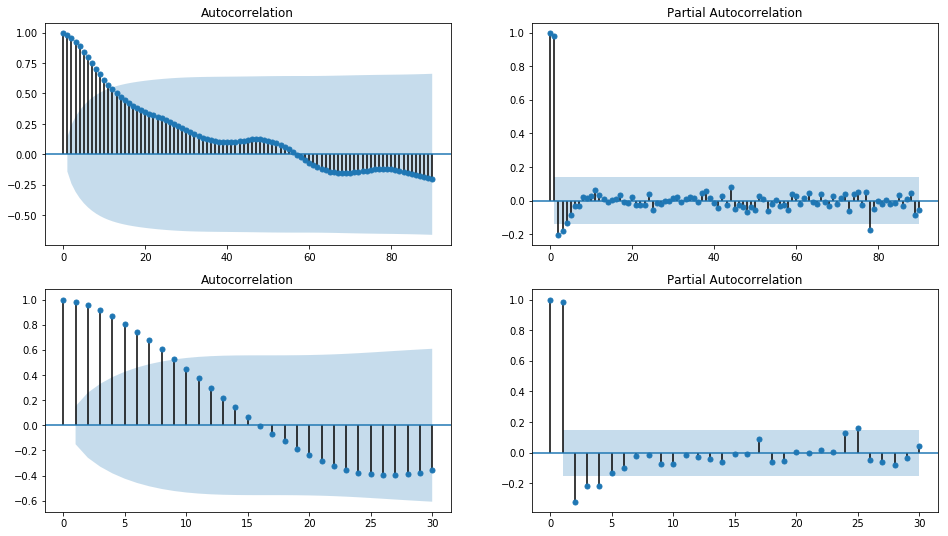

In [144]:
plot_acf(df_temp, X_temp, 'temp')

In [145]:
X_price.shape, X_temp.shape

((168, 5), (168, 5))

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


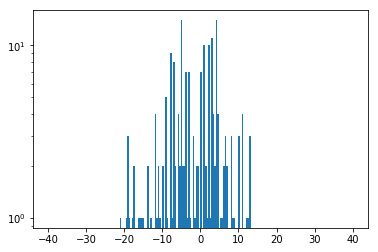

In [41]:
plt.hist(df_temp.temp_deseason, range = (-40, 40), bins = 200, log = True);

In [62]:
# stationarity test
temp_adf = adfuller(X_temp.temp.values, autolag='AIC')
temp_deseason_adf = adfuller(X_temp.temp_deseason.values, autolag='AIC')
adf_output(temp_adf)
adf_output(temp_deseason_adf)

Test Statistic                  -1.593117
p-value                          0.487050
# of Lags Used                   3.000000
Number of Observations Used    188.000000
Critical Value (10%)            -2.575032
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
dtype: float64
Test Statistic                  -3.182591
p-value                          0.021015
# of Lags Used                   3.000000
Number of Observations Used    188.000000
Critical Value (10%)            -2.575032
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
dtype: float64


<a id='granger'></a>
### Granger Causality
Granger Causality is a statistical method for testing the relationship between two time series. This can be a great way to supplement an analysis and move beyond simply plotting the decomposed time series.

At it's heart, this method asks whether values from a second time series provide more information about the future values of your first time series than just considering past values of the first time series:

"X is said to Granger-cause Y if Y can be better predicted using the histories of both X and Y than it can by using the history of Y alone." A good explanation of Granger Causality can be found [here](https://www.r-bloggers.com/chicken-or-the-egg-granger-causality-for-the-masses/) and [here](http://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html) (the first is much simpler, the second is for a real deep dive!).


An important caveat of Granger Causality is that it is very possible to find that X significantly Granger-causes Y, and simultaneously see that Y Granger-causes X. With well selected variables, you can curb this issue to some degree. For example, while maybe possible, it is much more likely that changes in temperature cause ice melting than ice melting causing changes in temperature. It may also be easier to get unidirectional causality in trend components rather than seasonal components.



In [43]:
scaler = StandardScaler()
X_price.loc[:,'norm'] = scaler.fit_transform(X_price.price_deseason.values.reshape(-1, 1))

scaler = StandardScaler()
X_temp.loc[:,'norm'] = scaler.fit_transform(X_temp.temp_deseason.values.reshape(-1, 1))

/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
# price is caused by temp, but price_deseason is not caused by temp_deseason or temp
# price_deseason is not caused by temp_deseason after normalization

# create a 2d dataframe to test if price is caused by temperature
# granger = pd.DataFrame({'price':X_price.price.values, 'temp':X_temp.temp.values})
# granger = granger.dropna()

# create a 2d dataframe to test if price is caused by temperature
granger = pd.DataFrame({'price':X_price.price_deseason.values, 'temp':X_temp.temp_deseason.values})
granger = granger.dropna()
# granger = pd.DataFrame({'price':X_price.norm, 'temp':X_temp.norm})
# granger = granger.dropna()

granger_test = grangercausalitytests(granger, maxlag=5)

In [50]:
# fig, ax = plt.subplots(figsize = (24, 9))
# ax.plot(df_price.iloc[:, 0], 
#         df_price.iloc[:, 1], color = 'black', label = 'Test');
# # ax.plot(df_price.iloc[:int(df_price.shape[0] * percentage), 0], 
# #         df_price.iloc[:int(df_price.shape[0] * percentage), 1], '.', color = 'black', label = 'Train');
# ax.plot(forecast.ds, 
#         forecast.yhat, linewidth = 4,
#         color = 'red', label = 'Prediction');
# #ax.fill_between(forecast.index, forecast.yhat_lower, forecast.yhat_upper)
# ax.tick_params(axis='both',which='both',labelsize=20,\
#         length=5,width=2,direction='out');
# ax.legend(fontsize = 32);
# #ax.set_ylim(-20, 2100)
# ax.set_ylim(0, 200)
# ax.set_xlim(pd.datetime(2017,1,1), pd.datetime(2018,2,5))
# #plt.savefig('prophet_2017.pdf', format = 'pdf')

In [82]:
X_price.columns

Index(['time_stamp', 'price', 'time_stamp_local', 'price_24hr_ago',
       'price_deseason', 'norm'],
      dtype='object')

In [172]:
model3=ARIMA(endog=X_price.price_deseason.values[:-1],
             exog=X_temp.temp_deseason.values[:-1],
             order=[3,0,3])
results3=model3.fit()
print(results3.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  167
Model:                     ARMA(3, 3)   Log Likelihood                -733.573
Method:                       css-mle   S.D. of innovations             19.307
Date:                Thu, 01 Feb 2018   AIC                           1485.146
Time:                        06:41:28   BIC                           1513.208
Sample:                             0   HQIC                          1496.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4500      3.338      0.434      0.665      -5.092       7.992
x1            -1.2450      0.408     -3.053      0.003      -2.044      -0.446
ar.L1.y       -0.5294      0.137     -3.859      0.0

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [173]:
results3.forecast(exog = [X_temp.temp_deseason.values[-1]], steps=1)[0]

array([ 19.23662544])

In [174]:
X_valid

array([ 35.92])

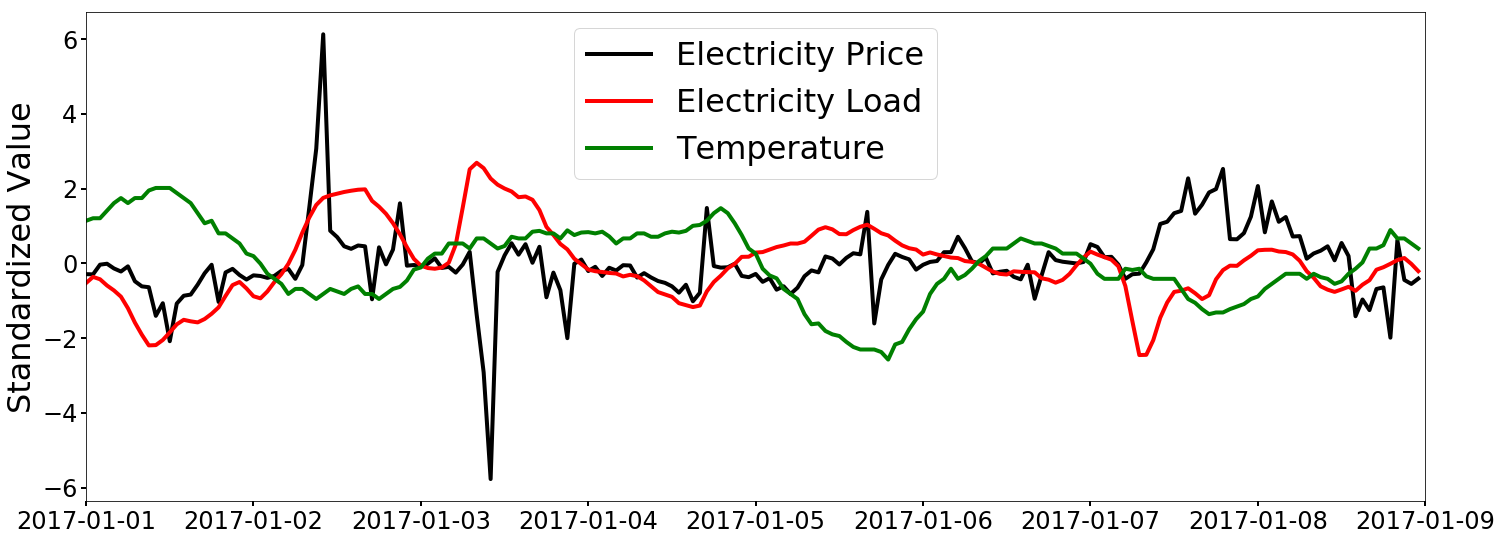

In [83]:
fig, ax = plt.subplots(figsize = (24, 9))
ax.plot(X_price.iloc[:,2], preprocessing.scale(X_price.iloc[:,4]), linewidth = 4
        , color = 'black', label = 'Electricity Price')
ax.plot(X_load.iloc[:,2], preprocessing.scale(X_load.iloc[:,4]), linewidth = 4
        , color = 'red', label = 'Electricity Load')
ax.plot(X_temp.iloc[:,2], preprocessing.scale(X_temp.iloc[:,4]), linewidth = 4
        , color = 'green', label = 'Temperature')
ax.legend(fontsize = 32)
ax.set_ylabel('Standardized Value', fontsize = 32)
ax.set_xlim(start_date + timedelta(days = 1), end_date)
# ax.set_ylim(-2, 11)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#plt.savefig('price_load_temp_2018.pdf', format = 'pdf')